# Flappy Bird Tabular: Q-Learning

## Background

**Value function**
It would be great to know how **good** a given state s is. Something to tell us: no matter the state we are in if we transition to state s your total reward will be x, word! If you start from s and follow policy π. That would spare us from revisiting same states over and over again. The value function does this for us. It depends on the state we are in s and the policy π your agent is following. It is given by:

![title](images/value_pi.png)

There exists an optimal value function that has the highest value for all states. It is given by:
![title](images/v_max.png)

**Q function**
Agent can not control what state it ends up in, directly. It can influence enviornment by choosing some action **a**. Let us introduce another function that accepts state and action as parameters and returns the expected total reward — the Q function (it represents the **quality** of a certain action given a state). More formally, the function Q^π(s, a) gives the expected return when starting in state **s**, performing action **a** and following π.

Again, we can define the optimal Q-function Q∗(s, a) that gives the expected total reward for your agent when starting at s and picks action a. That is, the optimal Q-function tells your agent how good of a choice is picking a when at state s.

There is a relationship between the two optimal functions V∗ and Q∗. It is given by:
![title](images/v_star.png)

That is, the maximum expected total reward when starting at s is the maximum of Q∗(s, a) over all possible actions.

Using Q∗(s, a) we can extract the optimal policy π∗ by choosing the action aa that gives maximum reward Q∗(s, a) for state s. We have:
![title](images/pi_star.png)


## Temporal-Difference (TD)

- TD is a combination of ideas from Monto-Carlo methods and DP methods
- TD methods learn directly from episodes of raw experience without a model, like MC
- TD methods update estimates based in part on other learned estimates, without waiting for a final outcome (i.e. they bootstrap), like DP
- TD updates a guess towards a guess
- General Update Rule: Q[s,a] += learning_rate * (td_target - Q[s,a]); where as (td_target - Q[s,a]) is called the TD Error
- TD Methods: 
- - Evaluation/Prediction: TD(0), TD(lambda)
- - Control: SARSA, Q-Learning

## Q-Learning

- Q-Learning is an Off-Policy, model-free algorithm based on well-known Bellman Equation
- Estimate Q* for the greedy behavior policy p:
- TD Target for Q-Learning: R[t+1] + discount_factor * max(Q[next_state])

**Algorithm**
![title](images/q_learning_algo.png)

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import gym
import datetime
from IPython import display
import numpy as np
import pandas as pd
import itertools
import sys
import os
import string
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

from matplotlib.cbook import MatplotlibDeprecationWarning
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from pylab import rc
import json
import random
#from itertools import izip
import seaborn as sns
sns.reset_orig()

import warnings
warnings.filterwarnings('ignore')   

In [3]:
%run flappy_bird_env_clone.py

In [4]:
class Agent(object):
    """
    The Agent class with utility methods   
    """
    def __init__(self,                
                 epsilon=.2, epsilon_decay=True, epsilon_decay_param=.01, 
                 tau=100, tau_decay=True, tau_decay_param=.01, 
                 policy_strategy='e-greedy'):
        
        """Initialize agent parameters.
        :param epsilon: Float value (0, 1) prob of taking random action vs. taking greedy action.
        :param epsilon_decay: Bool indicating whether to use decay of epsilon over episodes.
        :param epsilon_decay_param: Float param for decay given by epsilon*e^(-epsilon_decay_param * episode)
        :param tau: Float value for temp. param in the softmax, tau -> 0 = greedy, tau -> infinity = random.
        :param tau_decay: Bool indicating whether to use decay of tau over episodes.
        :param tau_decay_param: Float param for decay given by tau*e^(-tau_decay_param * episode)
        :param policy_strategy: String in {softmax, e-greedy, random}, exploration vs exploitation strategy.  
        """              
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_param = epsilon_decay_param
        self.tau = tau
        self.tau_decay = tau_decay
        self.tau_decay_param = tau_decay_param
        self.policy_strategy = policy_strategy  
        
        self.moves = []
        self.name = 'agent'
            
    #end def __init__  
    
    def choose_action(self, s):
        """Choose action for a TD algorithm that is updating using q values.

        The policy strategy for choosing an action is either chosen using a
        softmax strategy, epsilon greedy strategy, greedy strategy, or a random strategy.

        :param s: Integer index of the current state index the agent is in.

        :return a: Integer index of the chosen index for the action to take.
        """

        if self.policy_strategy == 'softmax':
            a = self.softmax(s)
        elif self.policy_strategy == 'e-greedy':
            a = self.epsilon_greedy(s)
        elif self.policy_strategy == 'greedy':
            a = self.random_policy(self.qvalues[s])
        else:
            a = np.random.choice(self.actions)

        return a
    
    def random_policy(self, list):
        
        """Helper function to get the argmax of an array breaking ties randomly.
        
        :param arr: 1D or 1D numpy array to find the argmax for.
    
        :return choice or argmax_array: Choice is integer index of array with 
        the max value, argmax_array is array of integer index of max value in each 
        row of the original array.
        """
    
        arr = np.array(list)
        
        if len(arr.shape) == 1:
            choice = np.random.choice(np.flatnonzero(arr == arr.max()))
            return choice
        else:
            N = arr.shape[0]
            argmax_array = np.zeros(N)
    
            for i in range(N):
                choice = np.random.choice(np.flatnonzero(arr[i] == arr[i].max()))
                argmax_array[i] = choice
    
        argmax_array = argmax_array.astype(int)
    
        return argmax_array
    
    #end def random_policy
    
    def epsilon_greedy(self, s):
        """Epsilon greedy exploration-exploitation strategy.

        This policy strategy selects the current best action with probability
        of 1 - epsilon, and a random action with probability epsilon.
        
        :param s: Integer index of the current state index the agent is in.

        :return a: Integer index of the chosen index for the agent to take.
        """

        if self.epsilon_decay:
            epsilon = self.epsilon * np.exp(-self.epsilon_decay_param * len(self.moves))
        else:
            epsilon = self.epsilon      
            
        if not np.random.binomial(1, epsilon):
            a = self.random_policy(self.qvalues[s])
        else:
            a = np.random.choice(self.actions)

        return a
    #end def epsilon_greedy
    
    def softmax(self, s):
        """Softmax exploration-exploitation strategy.

        This policy strategy uses a boltzman distribution with a temperature 
        parameter tau, to assign the probabilities of choosing an action based
        off of the current q value of the state and action.

        :param s: Integer index of the current state index the agent is in.

        :return a: Integer index of the chosen index for the agent to take.
        """

        if self.tau_decay:
            # Capping the minimum value of tau to prevent overflow issues.
            tau = max(self.tau * np.exp(-self.tau_decay_param * self.episode), .1)
        else:
            tau = self.tau

        if len(self.tau_choices) <= self.episode:
            self.tau_choices.append(tau)

        exp = lambda s, a: np.exp(self.qvalues[s, a]/tau)
        values = []
        probs = []

        for a in self.actions:
            # Catching overflow and returning random action if it occurs.
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    value = exp(s, a)
                except RuntimeWarning:
                    return self.random_policy(self.qvalues[s])

            values.append(value) 
        
        total = sum(values)
        probs = [val/total for val in values]

        try:
            sample = np.random.multinomial(1, probs).tolist()
            a = sample.index(1)
        except:
            # Return random action if there is a overflow issue.
            a = self.random_policy(self.qvalues[s])

        return a


In [5]:
class FlappyBirdAgent(Agent):
    """
    The Agent class that applies the Qlearning logic to Flappy bird game
    After every iteration (iteration = 1 game that ends with the bird dying) updates Q values
    After every SAVE_N iterations, saves the Q values to the local JSON file
    """
    def __init__(self,                
                 epsilon=.2, epsilon_decay=True, epsilon_decay_param=.01, 
                 tau=100, tau_decay=True, tau_decay_param=.01, 
                 policy_strategy='e-greedy'):
        
        """Initialize agent parameters.
        :param epsilon: Float value (0, 1) prob of taking random action vs. taking greedy action.
        :param epsilon_decay: Bool indicating whether to use decay of epsilon over episodes.
        :param epsilon_decay_param: Float param for decay given by epsilon*e^(-epsilon_decay_param * episode)
        :param tau: Float value for temp. param in the softmax, tau -> 0 = greedy, tau -> infinity = random.
        :param tau_decay: Bool indicating whether to use decay of tau over episodes.
        :param tau_decay_param: Float param for decay given by tau*e^(-tau_decay_param * episode)
        :param policy_strategy: String in {softmax, e-greedy, random}, exploration vs exploitation strategy.  
        """       
        
        super(FlappyBirdAgent, self).__init__(epsilon, epsilon_decay, epsilon_decay_param, 
                                                tau, tau_decay, tau_decay_param, 
                                                policy_strategy)
        
        self.gameCNT = 0 # Game count of current run, incremented after every death
        self.SAVE_N = 25 # Number of iterations to dump Q values to JSON after  
        
        self.load_qvalues()
        
    #end def __init__

    def load_qvalues(self):
        """
        Load q values from a JSON file
        """
        self.qvalues = {}
        try:
            fil = open('data/qvalues.json', 'r')
        except IOError:
            return
        self.qvalues = json.load(fil)
        fil.close()
    #end def load_qvalues
    
    def map_state(self, xdif, ydif, vel):
        """
        Map the (xdif, ydif, vel) to the respective state, with regards to the grids
        The state is a string, "xdif_ydif_vel"

        X -> [-40,-30...120] U [140, 210 ... 420]
        Y -> [-300, -290 ... 160] U [180, 240 ... 420]
        """
        if xdif < 140:
            xdif = int(xdif) - (int(xdif) % 10)
        else:
            xdif = int(xdif) - (int(xdif) % 70)

        if ydif < 180:
            ydif = int(ydif) - (int(ydif) % 10)
        else:
            ydif = int(ydif) - (int(ydif) % 60)

        return str(int(xdif))+'_'+str(int(ydif))+'_'+str(vel)
    #end def map_state
    
    def act(self, xdif, ydif, vel):
        """
        Chooses the best action with respect to the current state - Chooses 0 (don't flap) to tie-break
        """
        state = self.map_state(xdif, ydif, vel)

        self.moves.append( [self.last_state, self.last_action, state] ) # Add the experience to the history

        self.last_state = state # Update the last_state with the current state
                
        self.last_action = self.choose_action(state)
        
        return self.last_action   
       
    #end def act    
    
    
    def get_last_state(self):
        return self.last_state
    #end def get_last_state
   

    def save_qvalues(self):
        """
        Save the qvalues to the JSON file
        """
        if self.gameCNT % self.SAVE_N == 0:
            fil = open('data/qvalues.json', 'w')
            json.dump(self.qvalues, fil)
            fil.close()
            print('Q-values updated on local file.')
        #end if
    #end def save_qvalues

In [6]:
class FlappyBirdAgentQLearning(FlappyBirdAgent):
    """
    The Model Free Agent class that applies the Model Free algorithms to Flappy bird game
    After every iteration (iteration = 1 game that ends with the bird dying) updates Q values
    After every SAVE_N iterations, saves the Q values to the local JSON file
    """
    def __init__(self,
                 learning_rate = 0.7,
                 discount_factor = 1.0,
                 epsilon=.2, epsilon_decay=True, epsilon_decay_param=.01, 
                 tau=100, tau_decay=True, tau_decay_param=.01, 
                 policy_strategy='e-greedy'):
        
        """Initialize agent parameters.
        :param epsilon: Float value (0, 1) prob of taking random action vs. taking greedy action.
        :param epsilon_decay: Bool indicating whether to use decay of epsilon over episodes.
        :param epsilon_decay_param: Float param for decay given by epsilon*e^(-epsilon_decay_param * episode)
        :param tau: Float value for temp. param in the softmax, tau -> 0 = greedy, tau -> infinity = random.
        :param tau_decay: Bool indicating whether to use decay of tau over episodes.
        :param tau_decay_param: Float param for decay given by tau*e^(-tau_decay_param * episode)
        :param policy_strategy: String in {softmax, e-greedy, random}, exploration vs exploitation strategy.  
        """       
        super(FlappyBirdAgentQLearning, self).__init__(epsilon, epsilon_decay, epsilon_decay_param, 
                                                tau, tau_decay, tau_decay_param, 
                                                policy_strategy)
                
        self.discount = discount_factor
        self.r = {0: 1, 1: -1000} # Reward function
        self.lr = learning_rate        
        self.last_state = "420_240_0"
        self.last_action = 0
       
        self.actions = [0,1] # 0=down 1=up
        self.name = 'Flappy Bird Agent with Q-Learning'
                
    #end def __init__
    
    def learn(self):
        """
        Update qvalues via iterating over experiences
        """
        history = list(reversed(self.moves))

        # Flag if the bird died in the top pipe
        high_death_flag = True if int(history[0][2].split('_')[1]) > 120 else False

        # Q-learning score updates
        t = 1
        for exp in history:
            state = exp[0]
            act = exp[1]
            res_state = exp[2]

            # Select reward
            if t == 1 or t == 2:
                cur_reward = self.r[1]
            elif high_death_flag and act:
                cur_reward = self.r[1]
                high_death_flag = False
            else:
                cur_reward = self.r[0]

            # Update
            self.qvalues[state][act] = (1-self.lr) * (self.qvalues[state][act]) + \
                                        self.lr * ( cur_reward + self.discount * max(self.qvalues[res_state]) )
            t += 1
        #end for

        self.gameCNT += 1  # increase game count
        self.save_qvalues()  # save q values (if game count % SAVE_N == 0)
        self.moves = []  # clear history after updating strategies
        
        #lower exploration rate
        self.epsilon = max(0, self.epsilon - self.epsilon_decay_param)
    #end def learn

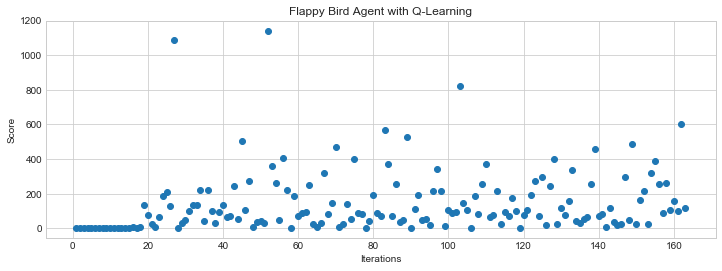

None

SystemExit: 

In [7]:
max_episodes = 10000
fbAgentQLearning = FlappyBirdAgentQLearning()
fbEnvQ = FlappyBirdEnviornment(fbAgentQLearning)

if __name__ == '__main__':        
    fbEnvQ.simulate(max_episodes) 